# LASSO Problem as a General Quadratic Problem

We want to write the LASSO problem as a general quadratic problem:

$$
\text{Minimize:} \quad \frac{1}{2} \| Xw - y \|_2^2 + \lambda \| w \|_1
$$

Define \( z = Xw \). The problem becomes:

$$
\text{Minimize:} \quad \frac{1}{2} \| z - y \|_2^2 + \lambda \| w \|_1
$$

Subject to:

$$
z = Xw
$$

The Lagrangian for this problem is:

$$
\mathcal{L}(w, z, p) = \frac{1}{2} \| z - y \|_2^2 + \lambda \| w \|_1 + p^T (Xw - z)
$$

Simplifying this expression, we have:

$$
\mathcal{L}(w, z, p) = \frac{1}{2} \| z - y \|_2^2 - p^T z + \lambda \| w \|_1 + p^T X w
$$

## Subproblem 1: Minimizing with Respect to \( w \)

For the first subproblem:

$$
\mathcal{L}_1(w, p) = \lambda \| w \|_1 + p^T X w
$$

For each \(i\), we have:

$$
\mathcal{L}_1(w_i, p) = (\lambda + \text{sgn}(w_i) p^T X) |w_i|
$$

The problem is minimized if:

$$
\| p^T X \|_\infty \leq \lambda
$$

Thus, the value of \( g_1(p) \) is:

$$
g_1(p) =
\begin{cases}
0 & \text{if } \| p^T X \|_\infty \leq \lambda \\
-\infty & \text{otherwise}
\end{cases}
$$

## Subproblem 2: Minimizing with Respect to \( z \)

The second subproblem is:

$$
\mathcal{L}_2(z, p) = \frac{1}{2} \| z - y \|_2^2 - p^T z
$$

To minimize, take the gradient and set it to zero:

$$
\nabla_{z} \mathcal{L}_2 = z - y - p = 0
$$

Thus:

$$
z = y + p
$$

The function \( g_2(p) \) is given by:

$$
g_2(p) = \frac{1}{2} \| p \|_2^2 + \| y \|_2^2 - p^T y
$$

## Combining the Subproblems

Combining the two subproblems, we obtain:

$$
\text{Maximize:} \quad -\frac{1}{2} \| p \|_2^2 - p^T y
$$

Subject to:

$$
\| p^T X \|_\infty \leq \lambda
$$


## Final Quadratic Program Form
We can rewrite it as:

$$
\text{Minimize } \frac{1}{2} p^T p + y^T p
$$

$$
\text{subject to } \|X p\|_\infty \leq \lambda
$$

By keeping the factor $\frac{1}{2}$, we retrieve the form of a general Quadratic problem with:

$$
\begin{cases}
Q = I \\
\rho = y \\
\gamma = 0
\end{cases}
$$

Moreover, the constraint can be seen as $2n$ inequality constraints:

$$
\begin{cases}
X p \leq \lambda 1_N \\
(-X) p \leq \lambda 1_N
\end{cases}
$$

By identifying:

$$
\begin{cases}
A = [X, -X] \\
b = \lambda 1_{2n}
\end{cases}
$$

So we have the form required at the end:

$$
\text{Minimize } \frac{1}{2} v^T Q v + \rho^T v
$$

$$
\text{subject to } A v \leq b, \quad v \in \mathbb{R}^N, \quad Q \succeq 0
$$



In [61]:
!pip install seaborn



In [66]:
import numpy as np
import pandas as pd
from math import *

import matplotlib.pyplot as plt

import seaborn as sns
print(plt.style.available)
plt.style.use('seaborn-v0_8')  # or any other style from plt.style.available



log10 = lambda x: log(x, 10)

sns.set(font_scale=1.3)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [67]:
def f0(v, Q, p):
    return v.T.dot(Q).dot(v) + p.T.dot(v)

def f(v, Q, p, b, A, t):
    if min([b[i]-A[i].dot(v) for i in range(A.shape[0])]) <= 0:
        return +1e10
    else:
        return t*v.T.dot(Q).dot(v) + t*p.T.dot(v) - sum([log(b[i]-A[i].dot(v)) for i in range(A.shape[0])])

def grad_f(v, Q, p, b, A, t):
    return 2*t*Q.dot(v) + t*p + np.sum([A[i]/(b[i]-A[i].dot(v)) for i in range(A.shape[0])], axis = 0)

def grad2_f(v, Q, b, A, t):
    sum_terms = [A[i].reshape(-1,1).dot(A[i].reshape(-1,1).T)/(b[i]-A[i].dot(v))**2 for i in range(A.shape[0])]
    return 2*t*Q + np.sum(sum_terms, axis = 0)

def admissible(v, A, b):
    return min([b[i]-A[i].dot(v) for i in range(A.shape[0])]) >= 0

In [68]:
def centering_step(Q, p, A, b, t, v, eps, alpha = 0.1, beta = 0.7):
    f_v = lambda v : f(v, Q, p, b, A, t)
    gf_v = lambda v : grad_f(v, Q, p, b, A, t)
    g2f_v = lambda v : grad2_f(v, Q, b, A, t)

    G_f = gf_v(v)
    G2_f = g2f_v(v)

    v_seq = [v]

    # Backtracking parameters
    alpha = alpha
    beta = beta

    # Compute the decrement
    get_lambda_2 = lambda G_f, G2_f : G_f.dot(np.linalg.inv(G2_f)).dot(G_f)
    lambda_2 = get_lambda_2(G_f, G2_f)
    while (lambda_2/2 > eps):
        # Compute the direction
        Dv_nt = -np.linalg.inv(G2_f).dot(G_f)

        # Backtracking line search
        s = 1
        while (f_v(v+s*Dv_nt) > f_v(v) + alpha*s*gf_v(v).T.dot(Dv_nt)):
            s = s*beta

        v = v+s*Dv_nt
        v_seq.append(v)

        G_f = gf_v(v)
        G2_f = g2f_v(v)
        lambda_2 = get_lambda_2(G_f, G2_f)
    return v_seq

In [69]:
def barr_method(Q, p, A, b, v0, eps, mu = 100, alpha = 0.1, beta = 0.7, t0 = 0.1):
    assert (A.dot(v0) < b).all(), "Error : v0 is no a feasible point !"
    # Initialize barrier coefficient
    t = t0
    m = len(b)//2

    v_seq = [v0]
    centering_path = [v0]

    inner_iterations, outer_iterations = 0, 0

    centering = centering_step(Q, p, A, b, t, v0, eps, alpha, beta)
    outer_iterations+=1
    inner_iterations+=len(centering)

    v = centering[-1]
    v_seq.append(v)
    while True:
        if m/t < eps:
            print("Finished in {} iterations".format(len(v_seq)-1))
            print("outer: ", outer_iterations)
            print("inner: ", inner_iterations)
            return v_seq, centering_path
        t *= mu
        centering = centering_step(Q, p, A, b, t, v, eps, alpha, beta)
        outer_iterations+=1
        inner_iterations+=len(centering)

        v = centering[-1]
        v_seq.append(v)
        centering_path += [v]*len(centering)

In [70]:
# Problem parameters
n = 200
m = 20
X = np.random.random_sample(size=(n, m))
#Y = np.random.random_sample(size=n)

w0 = np.random.random_sample(size=m)
Y = X.dot(w0) + np.random.normal(size=n)
lda = 10

# Dual parameters
Q = 1/2*np.eye(n)
p = Y
A = np.vstack((X.T, -X.T))
b = np.array([lda]*2*m)

In [71]:
eps = 1e-6
mu_tab = [2, 5, 15, 50, 100]
w_star_tab = []
delta_f_tab = []

f0_v = lambda v: f0(v, Q, p)

for mu in mu_tab:
    v = np.zeros(n)
    v_seq, path = barr_method(Q, p, A, b, v, eps, mu, alpha=0.1, beta = 0.6, t0=1)
    f_star = f0_v(v_seq[-1])
    # Retreive w
    w_star_tab.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(v_seq[-1] + Y))
    # Compute gap
    delta = np.array(list(map(f0_v, path))) - f_star
    delta = delta[delta > 0]
    delta_f_tab.append(delta)

Finished in 26 iterations
outer:  26
inner:  131
Finished in 12 iterations
outer:  12
inner:  65
Finished in 8 iterations
outer:  8
inner:  60
Finished in 6 iterations
outer:  6
inner:  53
Finished in 5 iterations
outer:  5
inner:  49


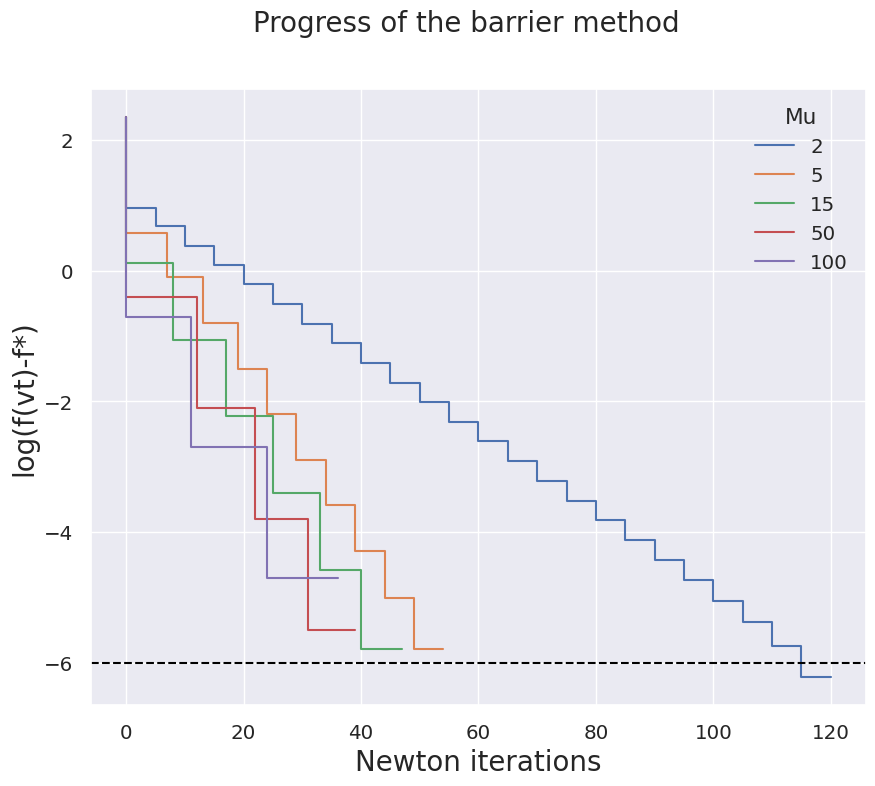

In [72]:
plt.figure(figsize=(10, 8))
plt.suptitle('Progress of the barrier method', size = 20)
for i in range(len(mu_tab)):
    plt.step(x = np.arange(0, len(delta_f_tab[i])),y=list(map(log10,delta_f_tab[i])), label = str(mu_tab[i]))
plt.axhline(y=log10(eps),c='black', linestyle='--')
plt.xlabel('Newton iterations', size = 20)
plt.ylabel('log(f(vt)-f*)', size = 20)
plt.legend(title='Mu')
#plt.savefig('Figures/barrier.png')

[]

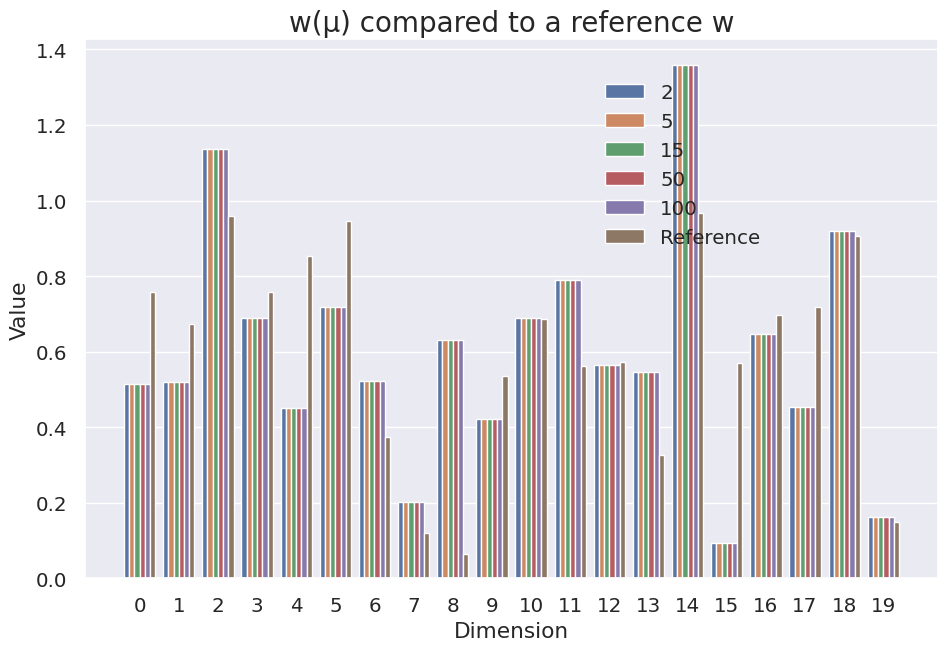

In [74]:
dt = pd.DataFrame({mu_tab[i]:w_star_tab[i] for i in range(len(mu_tab))})
dt['Reference'] = pd.Series(w0)
dt['Dimension'] = pd.Series(np.arange(m))
dt = dt.melt(id_vars='Dimension', var_name='Mu', value_name='Value')
plt.figure(figsize=(11, 7))
plt.title('w(µ) compared to a reference w', size = 20)
sns.barplot(data=dt, hue='Mu', y='Value', x='Dimension', palette='deep')
plt.legend(loc=(0.6, 0.6))
plt.plot()